# Bike sharing case study

## Objective

Identify the significance & extent of variables behind the demand for shared bikes in the American market

In [1]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [2]:
#load the dataset
inp0 = pd.read_csv('day.csv',header=0)
inp0.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


## I - Data understanding

**1. Number of rows & columns**

In [3]:
# number of rows & columns
inp0.shape

(730, 16)

In [4]:
#list all the columns
print(list(inp0.columns))

['instant', 'dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt']


**2. Presence of Null or NaN values**

In [5]:
#null values in each colummn
print('Null values : ', [inp0[i].isnull().sum() for i in inp0.columns])

Null values :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [6]:
print('NaN values : ', [inp0[i].isna().sum() for i in inp0.columns])

NaN values :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


**Observation** : No NULL nor NaN values present in dataset.

**3. Identification of data quality issues within the dataset**

In [7]:
inp0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


**Observations**<br>
1. instant : drop column because it contains index numbers which is not relevant for prediction.<br>
2. dteday  : subtract from 01.01.2018(assuming company inception) into a derived variable; drop column since already broken into
columns yr, mnth, weekday.<br>
3. season,weathersit,month,weekday  : categorical value so convert it into string values followed by encoding under data preparation.<br>
4. yr,mnth,cnt : rename column name.<br>
5. temp, atemp, hum, windspeed : round to 2 decimal spaces; standardize under data preparation.<br>
6. casual, registered : unknown during prediction as it requires more information;summation contained in column cnt so all 3 acting as target variable therefore drop these columns.<br>

## II - Data Manipulation

**1. yr,mnth,cnt : rename column name**

In [8]:
#inp0 - initial dataframe read from file
#inp1 - copy of inp0; data manipulation

inp1 = inp0.copy()
inp1.rename(columns={'yr':'year','mnth':'month','cnt':'count'},inplace=True)

**2. Derived metric : subtract dteday from 01.01.2018 assuming this was when the company started operations**

In [9]:
inp1['days_old']=(pd.to_datetime(inp1['dteday'],format= '%d-%m-%Y')-pd.to_datetime('01-01-2018',format= '%d-%m-%Y')).dt.days
inp1.head()

,instant,dteday,season,year,month,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,count,days_old
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985,0
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801,1
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349,2
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562,3
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600,4


**3. season,weathersit,month,weekday : categorical value so convert it into string values**

Season's numerical values & its corresponding categorical values:<br>
**1:spring<br>
2:summer<br>
3:fall<br>
4:winter**

In [10]:
inp1.season.value_counts()

3    188
2    184
1    180
4    178
Name: season, dtype: int64

In [11]:
inp1.season = inp1.season.map({1:'Spring', 2:'Summer', 3:'Fall', 4:'Winter'})

Description of the weather's numerical data & its corresponding categorical values:<br>
**1: Clear**     - Clear, Few clouds, Partly cloudy, Partly cloudy<br>
**2: Misty** - Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist<br>
**3: Light_snrn**      - Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds<br>
**4: Heavy_snrn**   - Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog<br>

In [12]:
inp1.weathersit.value_counts()

1    463
2    246
3     21
Name: weathersit, dtype: int64

In [13]:
inp1.weathersit = inp1.weathersit.map({1:'Clear',2:'Misty',3:'Light_snrn',4:'Heavy_snrn'})

In [14]:
inp1.month = inp1.month.apply(lambda x : calendar.month_abbr[x])

In [15]:
inp1.weekday = inp1.weekday.map({0:'Sun',1:'Mon',2:'Tue',3:'Wed',4:'Thu',5:'Fri',6:'Sat'})

In [16]:
inp1.head()

,instant,dteday,season,year,month,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,count,days_old
0,1,01-01-2018,Spring,0,Jan,0,Sat,0,Misty,14.110847,18.18125,80.5833,10.749882,331,654,985,0
1,2,02-01-2018,Spring,0,Jan,0,Sun,0,Misty,14.902598,17.68695,69.6087,16.652113,131,670,801,1
2,3,03-01-2018,Spring,0,Jan,0,Mon,1,Clear,8.050924,9.47025,43.7273,16.636703,120,1229,1349,2
3,4,04-01-2018,Spring,0,Jan,0,Tue,1,Clear,8.200000,10.60610,59.0435,10.739832,108,1454,1562,3
4,5,05-01-2018,Spring,0,Jan,0,Wed,1,Clear,9.305237,11.46350,43.6957,12.522300,82,1518,1600,4


**4. temp, atemp, hum, windspeed : round to 2 digits**

In [17]:
varlist = ['temp','atemp','hum','windspeed']
inp1[varlist] = inp1[varlist].apply(lambda x : round(x,2))

**5. instant, dteday, casual, registered : drop the columns**

In [18]:
inp1.drop(['instant','dteday','casual','registered'],axis=1,inplace=True)

In [19]:
inp1.shape

(730, 13)

In [20]:
inp1.head()

,season,year,month,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,count,days_old
0,Spring,0,Jan,0,Sat,0,Misty,14.11,18.18,80.58,10.75,985,0
1,Spring,0,Jan,0,Sun,0,Misty,14.90,17.69,69.61,16.65,801,1
2,Spring,0,Jan,0,Mon,1,Clear,8.05,9.47,43.73,16.64,1349,2
3,Spring,0,Jan,0,Tue,1,Clear,8.20,10.61,59.04,10.74,1562,3
4,Spring,0,Jan,0,Wed,1,Clear,9.31,11.46,43.70,12.52,1600,4


**6. Presence of outliers**

In [21]:
inp1.describe()

,year,holiday,workingday,temp,atemp,hum,windspeed,count,days_old
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,0.500000,0.028767,0.683562,20.319329,23.726384,62.765082,12.763699,4508.006849,364.500000
std,0.500343,0.167266,0.465405,7.506827,8.150247,14.237634,5.195640,1936.011647,210.877136
min,0.000000,0.000000,0.000000,2.420000,3.950000,0.000000,1.500000,22.000000,0.000000
25%,0.000000,0.000000,0.000000,13.810000,16.892500,52.000000,9.040000,3169.750000,182.250000
50%,0.500000,0.000000,1.000000,20.465000,24.370000,62.625000,12.130000,4548.500000,364.500000
75%,1.000000,0.000000,1.000000,26.882500,30.445000,72.990000,15.627500,5966.000000,546.750000
max,1.000000,1.000000,1.000000,35.330000,42.040000,97.250000,34.000000,8714.000000,729.000000


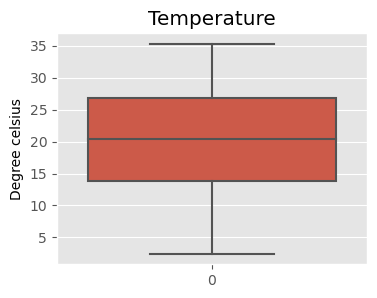

In [22]:
#box plot : temp
plt.figure(figsize=(4,3))
plt.title('Temperature')
plt.ylabel('Degree celsius')
sns.boxplot(inp1['temp'])
plt.show()

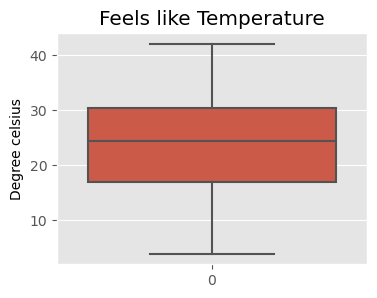

In [23]:
#box plot : atemp
plt.figure(figsize=(4,3))
plt.title('Feels like Temperature')
plt.ylabel('Degree celsius')
sns.boxplot(inp1['atemp'])
plt.show()

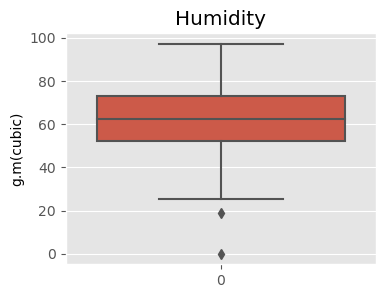

In [24]:
#box plot : hum
plt.figure(figsize=(4,3))
plt.title('Humidity')
plt.ylabel('g.m(cubic)')
sns.boxplot(inp1['hum'])
plt.show()

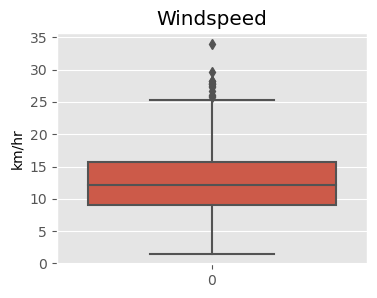

In [25]:
#box plot : windspeed
plt.figure(figsize=(4,3))
plt.title('Windspeed')
plt.ylabel('km/hr')
sns.boxplot(inp1['windspeed'])
plt.show()

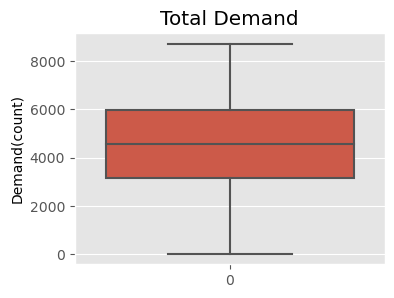

In [26]:
#box plot : count
plt.figure(figsize=(4,3))
plt.title('Total Demand')
plt.ylabel('Demand(count)')
sns.boxplot(inp1['count'])
plt.show()

**Observation**<br>
No presence of extreme outliers visible for temp, atemp, hum, windspeed & count.

## III - Exploratory Data Analysis

**1. Analysis of bike renting demand since inception of the company**

In [27]:
#value 0 = 2018 ; 1 = 2019
inp1.year.value_counts()

0    365
1    365
Name: year, dtype: int64

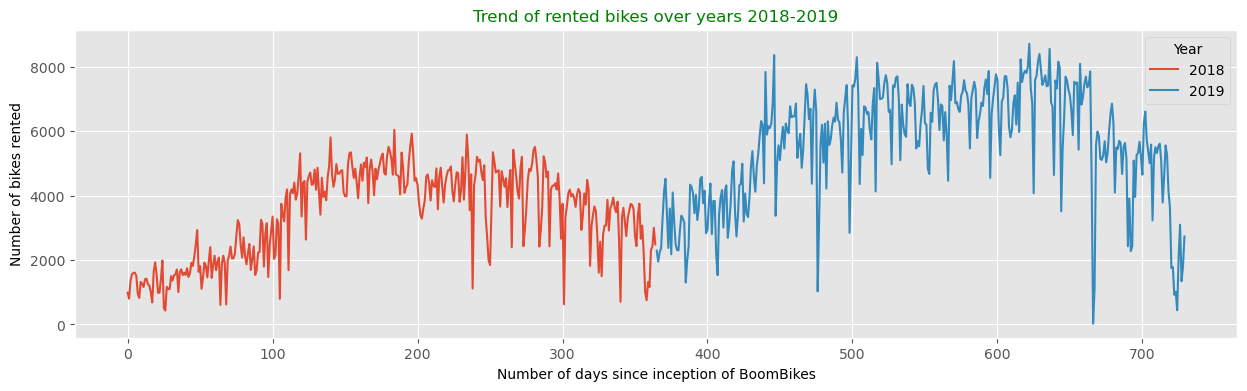

In [28]:
plt.figure(figsize=(15,4))
sns.lineplot(data=inp1,x='days_old', y='count',hue='year')
plt.title('Trend of rented bikes over years 2018-2019', fontdict={'fontsize':12,'fontweight':10,'color':'Green'})
plt.xlabel('Number of days since inception of BoomBikes')
plt.ylabel('Number of bikes rented')
L=plt.legend()
L.get_texts()[0].set_text('2018')
L.get_texts()[1].set_text('2019')
L.set_title('Year')
plt.show()

**Observation**<br>
1. demand curve for rented bikes almost similar in the years 2018 and 2019 in ratio.<br>
2. Dips in the demands are more severe in 2019 and occur in the first and later half of the year.<br>

**2. pairplot of features on the target to understand relationships between them**

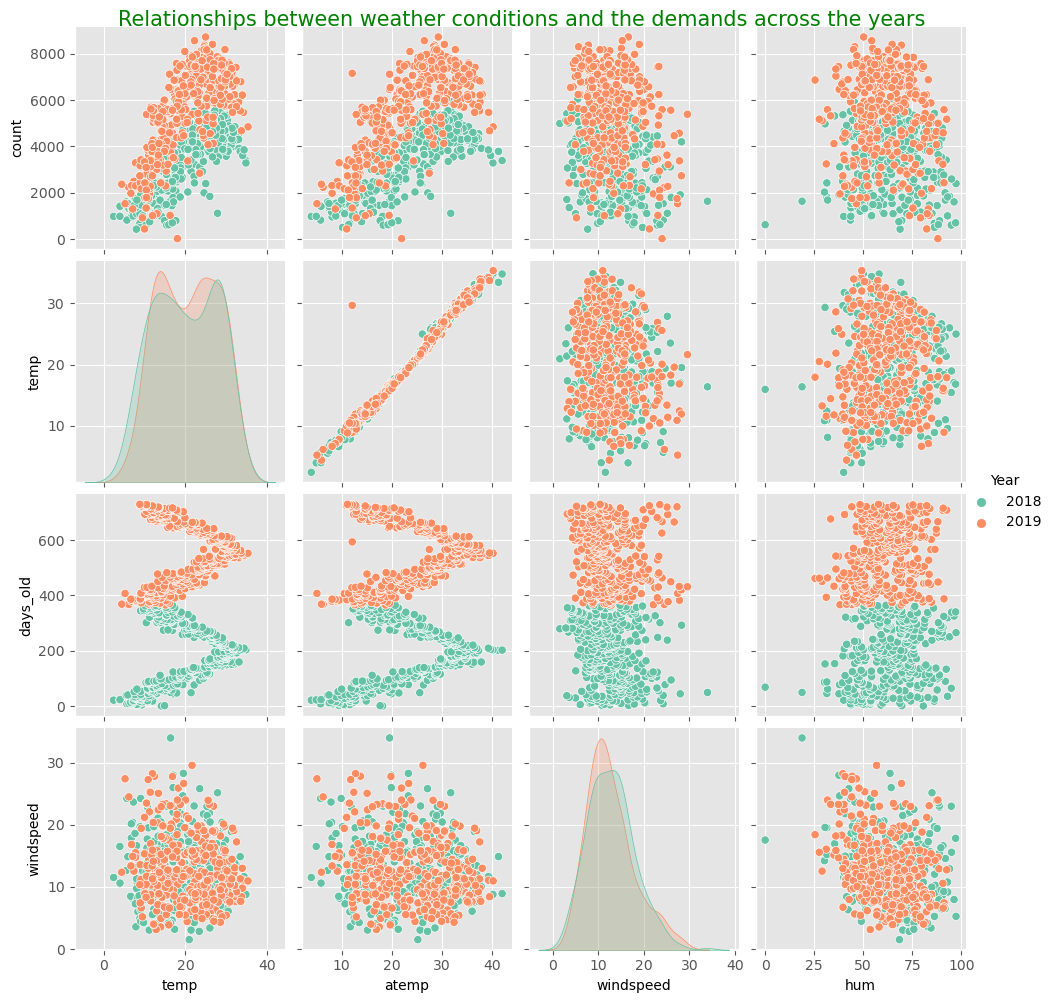

In [29]:
L = sns.pairplot(inp1, x_vars=['temp','atemp', 'windspeed','hum'],y_vars=['count','temp','days_old','windspeed'],
                 hue ='year',palette='Set2')
L.fig.suptitle('Relationships between weather conditions and the demands across the years',y=1,fontsize=15,color='Green')
L._legend.set_title('Year')
L._legend.get_texts()[0].set_text('2018')
L._legend.get_texts()[1].set_text('2019')
plt.show()

**Observations**<br>
1. increasing trend of demand with increasing temp and atemp with peaks between 20-30 degree celsius.<br>
2. temp and atemp have a positive increasing relationship.<br>
3. bike rentals are highest when windspeed is around 10-15 km/h.<br>
4. windspeed was higher in the year 2019 and so was the demand.<br>
5. majority of bike rentals are when humidity is within 50 and 80 g.m-3.<br>
6. temperature was comparatively higher in 2019 than 2018 but that did not stop the demand.<br>
7. Rise and low of temperature, windspeed & humidity between 2018 and 2019 follow same pattern.<br>

**3. Correlation between continuous features**

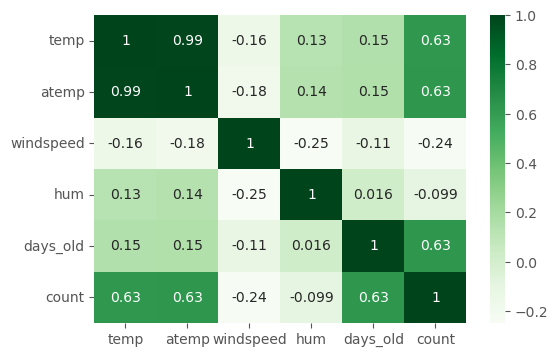

In [30]:
plt.figure(figsize=(6,4))
sns.heatmap(inp1[['temp','atemp','windspeed','hum','days_old','count']].corr(), cmap="Greens",annot=True)
plt.show()

**3. Analysis on relationship between seasons, months and particular continuous features**

**3.1 Analysis on seasons and months**

In [31]:
inp1.pivot_table(index='season', columns='month', values='count', fill_value=0,aggfunc=np.count_nonzero)

month,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
season,,,,,,,,,,,,
Fall,0,62,0,0,0,62,20,0,0,0,0,44
Spring,0,0,22,56,62,0,0,40,0,0,0,0
Summer,60,0,0,0,0,0,40,22,62,0,0,0
Winter,0,0,40,0,0,0,0,0,0,60,62,16


**Observation**<br>
Months that fall under the different seasons are:<br>
    `Fall` - Jun , Jul , Aug , Sep<br>
    `Spring` - Dec , Jan, Feb<br>
    `Summer` - Mar, Apr, Jun<br>
    `Winter` - Oct, Nov, Dec<br>
  Only Jun overlaps between `Fal` & `Summer`. There is no value in bucketing months since the categorical values are few and 
  each value can add more significance to the final model.

**3.2 Analysis on relationship between seasons & weathersit**

In [32]:
inp1.pivot_table(index='season', columns='weathersit', values='count', fill_value=0,aggfunc=np.count_nonzero)

weathersit,Clear,Light_snrn,Misty
season,,,
Fall,136,4,48
Spring,111,4,65
Summer,113,3,68
Winter,103,10,65


**Observation**<br>
1. Most of the demand for the bikes were in Fall when the weather was clear followed by Summer. <br>
2. Lowest bike rentals were during light snow/rain across all seasons.`

**3.3 Analysis of season over continuous features**

In [33]:
inp1.groupby('season')[['temp','atemp','windspeed','hum','days_old','count']].mean()

,temp,atemp,windspeed,hum,days_old,count
season,,,,,,
Fall,28.958936,32.794628,11.530426,63.348191,400.000000,5644.303191
Spring,12.196944,14.831278,14.387333,58.166778,260.611111,2608.411111
Summer,22.320652,26.015598,13.634946,62.694728,307.000000,4992.331522
Winter,17.339213,20.777360,11.523764,66.871910,491.500000,4728.162921


**Observation**<br>
1. Seasons with increasing humidity = Winter > Fall > Summer > Spring when comparing means.<br>
2. Seasons with increasing temperature = Fall > Summer > Winter > Spring.<br>
3. windspeed is almost the same across all seasons, therefore it can be assumed to play no role in the demand.<br>
4. Seasons with increasing demand = Fall > Summer > Winter > Spring(far lowest).

**4. Analysis of relationship across years, months & demands**

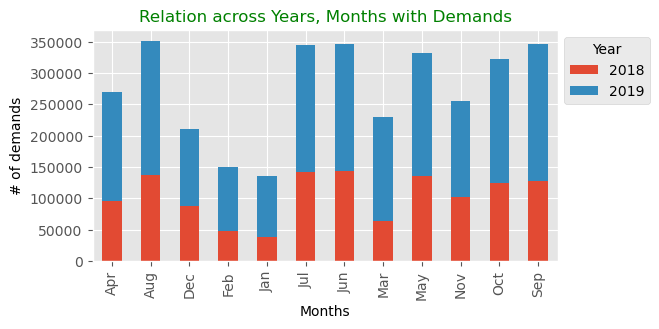

In [34]:
inp1.pivot_table(index = 'month',columns='year',values='count', aggfunc=np.sum ).plot(kind='bar',stacked=True,figsize=[6,3])
plt.title('Relation across Years, Months with Demands', fontdict={'fontsize':12,'fontweight':10,'color':'Green'})
plt.legend(title='Year',labels=['2018','2019'],loc='upper left', bbox_to_anchor=(1, 1))
plt.ylabel('# of demands')
plt.xlabel('Months')
plt.show()

**Observation**<br>
1. Demand in 2019 increased drastically across all months.<br>
2. Jun , Jul & Aug had the highest demand in both years

**5. Analysis of relationship across years, seasons & demands**

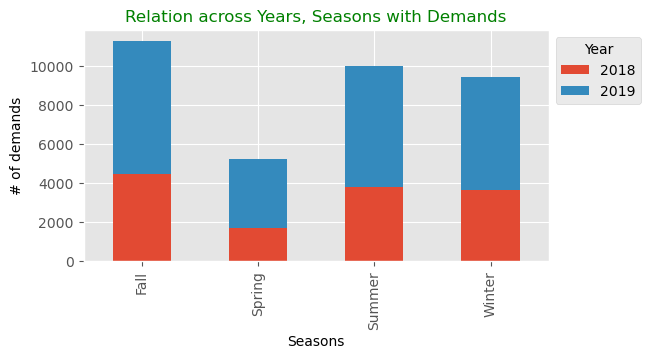

In [35]:
inp1.pivot_table(index = 'season',columns='year',values='count',aggfunc=np.mean).plot(kind='bar',stacked=True,figsize=[6,3])
plt.title('Relation across Years, Seasons with Demands', fontdict={'fontsize':12,'fontweight':10,'color':'Green'})
plt.legend(title='Year',labels=['2018','2019'],loc='upper left', bbox_to_anchor=(1, 1))
plt.ylabel('# of demands')
plt.xlabel('Seasons')
plt.show()

**Observation**<br>
2019 had the most demand across all season, with Fall having the highest.

**6. Analysis on holiday, workingday, weekday**

**6.1 Relationship on holiday & weekday**

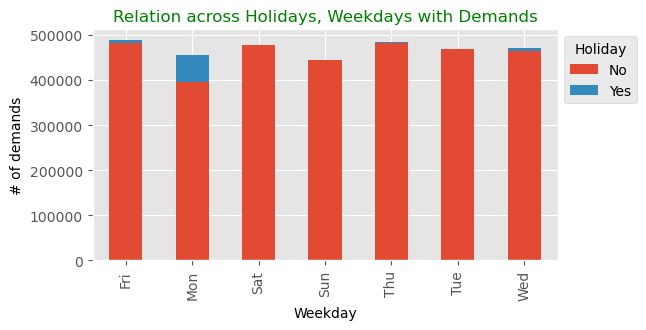

In [36]:
inp1.pivot_table(index = 'weekday',columns='holiday',values='count',aggfunc='sum' ).plot(kind='bar',
                                                                                           stacked=True,figsize=[6,3])
plt.title('Relation across Holidays, Weekdays with Demands', fontdict={'fontsize':12,'fontweight':10,'color':'Green'})
plt.legend(title='Holiday',labels=['No','Yes'],loc='upper left', bbox_to_anchor=(1, 1))
plt.ylabel('# of demands')
plt.xlabel('Weekday')
plt.show()

**Observation**<br>
Clear majority of the rented bikes were on non-holidays but there is no clear pattern on which day it is.

**6.1 Relationship on workingday & weekday**

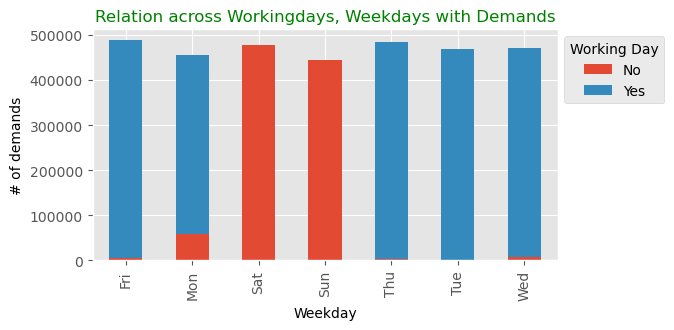

In [37]:
inp1.pivot_table(index = 'weekday',columns='workingday',values='count',aggfunc='sum' ).plot(kind='bar',
                                                                                           stacked=True,figsize=[6,3])
plt.title('Relation across Workingdays, Weekdays with Demands', fontdict={'fontsize':12,'fontweight':10,'color':'Green'})
plt.legend(title='Working Day',labels=['No','Yes'],loc='upper left', bbox_to_anchor=(1, 1))
plt.ylabel('# of demands')
plt.xlabel('Weekday')
plt.show()

**Observation**<br>
Here too, no clear pattern on which day might be preferred by the renters.

**7. Relationship between weather conditions and the demand across the years**

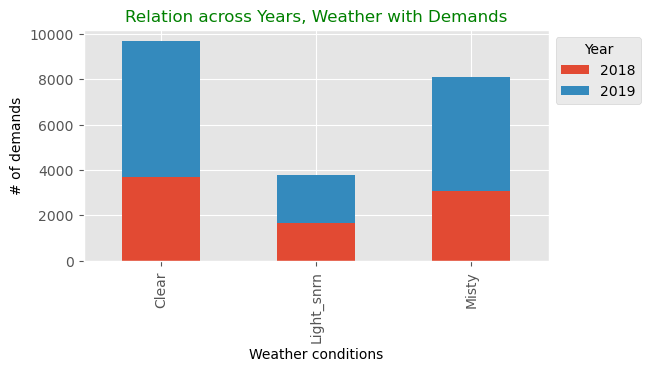

In [38]:
inp1.pivot_table(index = 'weathersit',columns='year',values='count',aggfunc=np.mean).plot(kind='bar',stacked=True,figsize=[6,3])
plt.title('Relation across Years, Weather with Demands', fontdict={'fontsize':12,'fontweight':10,'color':'Green'})
plt.legend(title='Year',labels=['2018','2019'],loc='upper left', bbox_to_anchor=(1, 1))
plt.ylabel('# of demands')
plt.xlabel('Weather conditions')
plt.show()

**Observation**<br>
High demands during Clear whether conditions with least during light snow/rain.

**8. Relationship between seasons and weather and the demands**

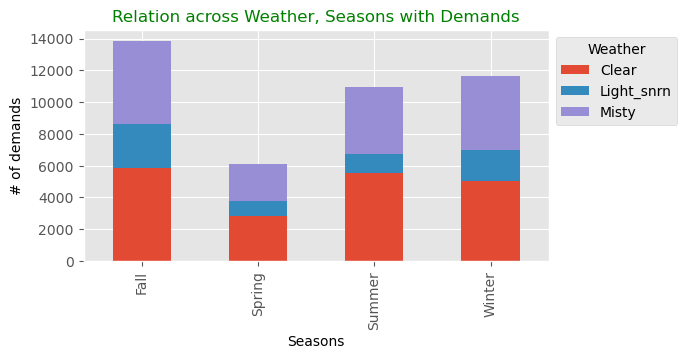

In [39]:
inp1.pivot_table(index = 'season',columns='weathersit',values='count',aggfunc=np.mean).plot(kind='bar',stacked=True,figsize=[6,3])
plt.title('Relation across Weather, Seasons with Demands', fontdict={'fontsize':12,'fontweight':10,'color':'Green'})
plt.legend(title='Weather',loc='upper left', bbox_to_anchor=(1, 1))
plt.ylabel('# of demands')
plt.xlabel('Seasons')
plt.show()

**Observation**<br>
In addition to previous observations, there is also a demand during light snow/rains during Fall and winter seasons.

## IV - Data Preparation

**1. Create dummy variables for all categorical features: season, weathersit, month, weekday**

In [40]:
#season
status_s = pd.get_dummies(inp1['season'])
status_s.value_counts()

Fall  Spring  Summer  Winter
1     0       0       0         188
0     0       1       0         184
      1       0       0         180
      0       0       1         178
dtype: int64

Seasons are identifed as follows:<br>
    1. `1000` will correspond to  `fall`<br>
    2. `0010` will correspond to `spring`<br>
    3. `0100` will correspond to `summer`<br>
    4. `0001` will correspond to `winter`<br>
`fall` columns is redundant so dropping it therefore seasons are now identified as follows:<br>
    1. `000` will correspond to `fall`<br>
    2. `010` will correspond to `spring`<br>
    3. `100` will correspond to `summer`<br>
    4. `001` will correspond to `winter`<br>

In [41]:
#drop column fall from the dummies
status_s = pd.get_dummies(inp1['season'],drop_first=True)
status_s.value_counts()

Spring  Summer  Winter
0       0       0         188
        1       0         184
1       0       0         180
0       0       1         178
dtype: int64

In [42]:
#inp1 = EDA dataset
#inp2 = copy of inp1; dummy variable additions with dropping of categorical features
inp2 = inp1.copy()
inp2 = pd.concat([inp2,status_s],axis=1)
inp2.head()

,season,year,month,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,count,days_old,Spring,Summer,Winter
0,Spring,0,Jan,0,Sat,0,Misty,14.11,18.18,80.58,10.75,985,0,1,0,0
1,Spring,0,Jan,0,Sun,0,Misty,14.90,17.69,69.61,16.65,801,1,1,0,0
2,Spring,0,Jan,0,Mon,1,Clear,8.05,9.47,43.73,16.64,1349,2,1,0,0
3,Spring,0,Jan,0,Tue,1,Clear,8.20,10.61,59.04,10.74,1562,3,1,0,0
4,Spring,0,Jan,0,Wed,1,Clear,9.31,11.46,43.70,12.52,1600,4,1,0,0


In [43]:
#repeat for  month, weekday & weathersit
status_m = pd.get_dummies(inp1['month'],drop_first=True)
status_w = pd.get_dummies(inp1['weekday'],drop_first=True)
status_wit = pd.get_dummies(inp1['weathersit'],drop_first=True)
inp2 = pd.concat([inp2,status_m,status_w,status_wit],axis=1)

#drop the categorical columns
inp2.drop(['season','month','weekday','weathersit'],axis=1,inplace=True)

inp2.head()

,year,holiday,workingday,temp,atemp,hum,windspeed,count,days_old,Spring,...,Oct,Sep,Mon,Sat,Sun,Thu,Tue,Wed,Light_snrn,Misty
0,0,0,0,14.11,18.18,80.58,10.75,985,0,1,...,0,0,0,1,0,0,0,0,0,1
1,0,0,0,14.90,17.69,69.61,16.65,801,1,1,...,0,0,0,0,1,0,0,0,0,1
2,0,0,1,8.05,9.47,43.73,16.64,1349,2,1,...,0,0,1,0,0,0,0,0,0,0
3,0,0,1,8.20,10.61,59.04,10.74,1562,3,1,...,0,0,0,0,0,0,1,0,0,0
4,0,0,1,9.31,11.46,43.70,12.52,1600,4,1,...,0,0,0,0,0,0,0,1,0,0


In [44]:
print(list(inp2.columns))

['year', 'holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed', 'count', 'days_old', 'Spring', 'Summer', 'Winter', 'Aug', 'Dec', 'Feb', 'Jan', 'Jul', 'Jun', 'Mar', 'May', 'Nov', 'Oct', 'Sep', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed', 'Light_snrn', 'Misty']


**2. Divide dataset into train & test datasets**

In [45]:
#divide dataset into train & test datasets in 70:30 ratio
np.random.seed(0)
inp2_train, inp2_test = train_test_split(inp2, train_size = 0.7, test_size = 0.3, random_state = 100)
print('Train dataset size =',inp2_train.shape)
print('Test dataset size =',inp2_test.shape)

Train dataset size = (510, 31)
Test dataset size = (219, 31)


**3. Perform scaling of continuous variables : temp, atemp, hum, windspeed,count**

In [46]:
scaler = MinMaxScaler()
num_vars = ['temp','atemp','hum','windspeed','count','days_old']
inp2_train[num_vars] = scaler.fit_transform(inp2_train[num_vars])
inp2_train.head()

,year,holiday,workingday,temp,atemp,hum,windspeed,count,days_old,Spring,...,Oct,Sep,Mon,Sat,Sun,Thu,Tue,Wed,Light_snrn,Misty
653,1,0,1,0.509875,0.501181,0.575330,0.300930,0.864243,0.896978,0,...,1,0,0,0,0,0,1,0,0,0
576,1,0,1,0.815254,0.766343,0.725680,0.264678,0.827658,0.791209,0,...,0,0,0,0,0,0,1,0,0,0
426,1,0,0,0.442419,0.438960,0.640148,0.255374,0.465255,0.585165,1,...,0,0,0,1,0,0,0,0,0,1
728,1,0,0,0.245214,0.200315,0.498042,0.663138,0.204096,1.000000,1,...,0,0,0,0,1,0,0,0,0,0
482,1,0,0,0.395624,0.391966,0.504534,0.188643,0.482973,0.662088,0,...,0,0,0,1,0,0,0,0,0,1


**4. Divide dataset features into dependent & independent variables**

In [47]:
#depedent variable = count
#indepdent variable = rest of features

y_train = inp2_train.pop('count')
X_train = inp2_train

## V - Linear Regression model building

**1. Recursive Feature Elimination (RFE) on the X_train & y_train to find relevant independent features**

In [48]:
#RFE - Recursive feature elimination
lm = LinearRegression()
lm.fit(X_train,y_train)

rfe = RFE(lm,n_features_to_select=25)
rfe = rfe.fit(X_train,y_train)

In [49]:
#list the output of RFE rankig
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('year', True, 1),
 ('holiday', True, 1),
 ('workingday', True, 1),
 ('temp', True, 1),
 ('atemp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('days_old', True, 1),
 ('Spring', True, 1),
 ('Summer', True, 1),
 ('Winter', True, 1),
 ('Aug', True, 1),
 ('Dec', True, 1),
 ('Feb', True, 1),
 ('Jan', True, 1),
 ('Jul', True, 1),
 ('Jun', False, 4),
 ('Mar', False, 6),
 ('May', True, 1),
 ('Nov', True, 1),
 ('Oct', True, 1),
 ('Sep', True, 1),
 ('Mon', True, 1),
 ('Sat', True, 1),
 ('Sun', True, 1),
 ('Thu', False, 3),
 ('Tue', False, 2),
 ('Wed', False, 5),
 ('Light_snrn', True, 1),
 ('Misty', True, 1)]

In [50]:
#features selected by RFE
col = X_train.columns[rfe.support_]
print(list(col))

['year', 'holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed', 'days_old', 'Spring', 'Summer', 'Winter', 'Aug', 'Dec', 'Feb', 'Jan', 'Jul', 'May', 'Nov', 'Oct', 'Sep', 'Mon', 'Sat', 'Sun', 'Light_snrn', 'Misty']


In [51]:
#features not selected by RFE
print(list(X_train.columns[~rfe.support_]))

['Jun', 'Mar', 'Thu', 'Tue', 'Wed']


**2. Iteration of building the model based on RFE**

**2.1 Model 1 : based on all indepdent features determined from RFE**

In [52]:
#relevant independent features determined by RFE
X_train_rfe = X_train[col]
X_train_rfe.shape

(510, 25)

In [53]:
#add constant; build the linear model
X_train_rfe = sm.add_constant(X_train_rfe)
lm = sm.OLS(y_train,X_train_rfe).fit()

In [54]:
#Model 1 statistics
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     117.1
Date:                Sat, 26 Aug 2023   Prob (F-statistic):          1.50e-184
Time:                        18:00:53   Log-Likelihood:                 527.16
No. Observations:                 510   AIC:                            -1004.
Df Residuals:                     485   BIC:                            -898.5
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2478      0.038      6.542      0.0

**Observation**<br>
1. Features atemp(highly correlated to temp as confirmed from EDA), days_old, Aug, Dec, Nov, Oct, Mon are dropped since the p-value is high in comparison to the p-value of other features and greated than 0.2.<br>
2. R2 is 85.3 and adjusted R2 is 84.6 with probability of F-statistic well below 0.05 implying a good model fit.

**2.2 Model 2 : without features atemp, days_old, Aug, Dec, Nov, Oct, Mon**

In [55]:
print(list(X_train_rfe.columns))

['const', 'year', 'holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed', 'days_old', 'Spring', 'Summer', 'Winter', 'Aug', 'Dec', 'Feb', 'Jan', 'Jul', 'May', 'Nov', 'Oct', 'Sep', 'Mon', 'Sat', 'Sun', 'Light_snrn', 'Misty']


In [56]:
#copy model 2 indepdent features;drop features that are insignificant
X_train_m2 = X_train_rfe.drop(['atemp','days_old','Aug','Dec','Nov','Oct','Mon'],axis=1)

In [57]:
print(list(X_train_m2.columns))

['const', 'year', 'holiday', 'workingday', 'temp', 'hum', 'windspeed', 'Spring', 'Summer', 'Winter', 'Feb', 'Jan', 'Jul', 'May', 'Sep', 'Sat', 'Sun', 'Light_snrn', 'Misty']


In [58]:
X_train_m2.shape

(510, 19)

In [59]:
X_train_m2 = sm.add_constant(X_train_m2)
lm = sm.OLS(y_train,X_train_m2).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     163.0
Date:                Sat, 26 Aug 2023   Prob (F-statistic):          1.59e-189
Time:                        18:00:53   Log-Likelihood:                 520.91
No. Observations:                 510   AIC:                            -1006.
Df Residuals:                     492   BIC:                            -929.6
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2181      0.029      7.563      0.0

**Observation**<br>
1. R2 and adjusted R2 is 84.9 and 84.4 respectively with probability of F-statistics defining a well fit model. <br>
2. p-value of holiday & Feb is now high. Features holiday, workingday, Sat & Sun are all related as Sat & Sun can be identified
with either holiday or workingday and in general any day can be identified using workingday. Therefore, features holiday, Sat &
Sun can be dropped.

In [60]:
print(list(X_train_m2.columns))

['const', 'year', 'holiday', 'workingday', 'temp', 'hum', 'windspeed', 'Spring', 'Summer', 'Winter', 'Feb', 'Jan', 'Jul', 'May', 'Sep', 'Sat', 'Sun', 'Light_snrn', 'Misty']


In [61]:
#drop constant to find VIF
X_train_m2 = X_train_m2.drop(['const'],axis=1)

In [62]:
#create VIF for Model 2
vif = pd.DataFrame()
X = X_train_m2
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,workingday,55.13
14,Sat,13.25
15,Sun,12.75
6,Spring,5.67
3,temp,4.09
8,Winter,3.68
7,Summer,3.28
1,holiday,3.11
10,Jan,2.05
4,hum,1.95


**Observation**<br>
`Guideline:` <br>
    1. VIF > 10 is eliminated due to high multicollinearity.<br>
    2. VIF > 5 is ok but worth inspecting.<br>
    3. VIF < 5 is good.<br>
    <br>
 **Action**<br>
 1. p-values of Sat & Sun explain the p-values & VIF of workingday can be explained by its relation to Sat, Sun & holiday. Reconfirms the decision to drop these features

**2.3 Model 3 : without features holiday, Sat, Sun & Feb**

In [63]:
print(list(X_train_m2.columns))

['year', 'holiday', 'workingday', 'temp', 'hum', 'windspeed', 'Spring', 'Summer', 'Winter', 'Feb', 'Jan', 'Jul', 'May', 'Sep', 'Sat', 'Sun', 'Light_snrn', 'Misty']


In [64]:
#model 3
X_train_m3 = X_train_m2.drop(['Feb','holiday','Sat','Sun'],axis=1)

In [65]:
print(list(X_train_m3))

['year', 'workingday', 'temp', 'hum', 'windspeed', 'Spring', 'Summer', 'Winter', 'Jan', 'Jul', 'May', 'Sep', 'Light_snrn', 'Misty']


In [66]:
X_train_m3.shape

(510, 14)

In [67]:
X_train_m3 = sm.add_constant(X_train_m3)
lm = sm.OLS(y_train,X_train_m3).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     187.5
Date:                Sat, 26 Aug 2023   Prob (F-statistic):          1.69e-187
Time:                        18:00:54   Log-Likelihood:                 507.92
No. Observations:                 510   AIC:                            -985.8
Df Residuals:                     495   BIC:                            -922.3
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2866      0.036      7.864      0.0

**Observation**<br>
1.R2 and adjusted R2 is 84.1 and 83.7 respectively with probability of F-statistics defining a well fit model.<br>
2. p-values of feature May is high in comparison to rest. Decision to drop this.

In [68]:
print(list(X_train_m3.columns))

['const', 'year', 'workingday', 'temp', 'hum', 'windspeed', 'Spring', 'Summer', 'Winter', 'Jan', 'Jul', 'May', 'Sep', 'Light_snrn', 'Misty']


In [69]:
#drop constant to find VIF
X_train_m3 = X_train_m3.drop(['const'],axis=1)

#create VIF for Model 3
vif = pd.DataFrame()
X = X_train_m3
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
3,hum,29.29
2,temp,17.17
4,windspeed,4.76
5,Spring,4.39
7,Winter,3.38
6,Summer,3.32
1,workingday,3.04
13,Misty,2.28
0,year,2.10
8,Jan,1.67


**Observation**<br>
1. Even though VIF for feature hum is high, its p-value is low. Unclear at this point whether to remove this feature now
therefore retain it and check once more after removing May.

**2.4 Model 4 : without feature May**

In [70]:
print(list(X_train_m3.columns))

['year', 'workingday', 'temp', 'hum', 'windspeed', 'Spring', 'Summer', 'Winter', 'Jan', 'Jul', 'May', 'Sep', 'Light_snrn', 'Misty']


In [71]:
#model 4
X_train_m4 = X_train_m3.drop(['May'],axis=1)

In [72]:
X_train_m4 = sm.add_constant(X_train_m4)
lm = sm.OLS(y_train,X_train_m4).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     201.7
Date:                Sat, 26 Aug 2023   Prob (F-statistic):          2.12e-188
Time:                        18:00:54   Log-Likelihood:                 507.30
No. Observations:                 510   AIC:                            -986.6
Df Residuals:                     496   BIC:                            -927.3
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2787      0.036      7.799      0.0

**Observation**<br>
1. R2 is 84.1 and adjusted R2 is 83.7 with probability of F-statistic being low implying well defined model.<br>
2. p-value of Jan is high in comparison to rest. 

In [73]:
print(list(X_train_m4.columns))

['const', 'year', 'workingday', 'temp', 'hum', 'windspeed', 'Spring', 'Summer', 'Winter', 'Jan', 'Jul', 'Sep', 'Light_snrn', 'Misty']


In [74]:
X_train_m4.shape

(510, 14)

In [75]:
#drop constant to find VIF
X_train_m4 = X_train_m4.drop(['const'],axis=1)

#create VIF for Model 3
vif = pd.DataFrame()
X = X_train_m4
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
3,hum,29.27
2,temp,17.12
4,windspeed,4.66
5,Spring,4.38
7,Winter,3.38
1,workingday,3.04
6,Summer,2.80
12,Misty,2.28
0,year,2.09
8,Jan,1.67


**Observation**<br>
VIF of hum is still high. One more check once Jan is removed.

**2.5 Module 5 : without feature Jan**

In [76]:
print(list(X_train_m4.columns))

['year', 'workingday', 'temp', 'hum', 'windspeed', 'Spring', 'Summer', 'Winter', 'Jan', 'Jul', 'Sep', 'Light_snrn', 'Misty']


In [77]:
#model 5
X_train_m5 = X_train_m4.drop(['Jan'],axis=1)

In [78]:
X_train_m5 = sm.add_constant(X_train_m5)
lm = sm.OLS(y_train,X_train_m5).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     217.0
Date:                Sat, 26 Aug 2023   Prob (F-statistic):          8.62e-189
Time:                        18:00:54   Log-Likelihood:                 505.43
No. Observations:                 510   AIC:                            -984.9
Df Residuals:                     497   BIC:                            -929.8
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2668      0.035      7.562      0.0

**Observation**<br>
All p-values look good. Based on this, no feature to drop at this point therefore check with VIF.

In [79]:
print(list(X_train_m5.columns))

['const', 'year', 'workingday', 'temp', 'hum', 'windspeed', 'Spring', 'Summer', 'Winter', 'Jul', 'Sep', 'Light_snrn', 'Misty']


In [80]:
X_train_m5.shape

(510, 13)

In [81]:
#drop constant to find VIF
X_train_m5 = X_train_m5.drop(['const'],axis=1)

#create VIF for Model 3
vif = pd.DataFrame()
X = X_train_m5
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
3,hum,28.30
2,temp,16.41
4,windspeed,4.65
5,Spring,4.06
7,Winter,3.35
1,workingday,3.04
6,Summer,2.80
11,Misty,2.28
0,year,2.08
8,Jul,1.58


**Observation**<br>
Even though VIF of humidity is high, it is directly correlated to feature Summer & negatively correlated to windspeed as seen in the correlation heatmap under EDA. Therefore, remove Summer first to begin with before proceeding any further.

**2.6 Module 6 : without feature Summer**

In [82]:
print(list(X_train_m5.columns))

['year', 'workingday', 'temp', 'hum', 'windspeed', 'Spring', 'Summer', 'Winter', 'Jul', 'Sep', 'Light_snrn', 'Misty']


In [83]:
#model 6
X_train_m6 = X_train_m5.drop(['Summer'],axis=1)

In [84]:
X_train_m6 = sm.add_constant(X_train_m6)
lm = sm.OLS(y_train,X_train_m6).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     230.6
Date:                Sat, 26 Aug 2023   Prob (F-statistic):          2.02e-187
Time:                        18:00:55   Log-Likelihood:                 499.35
No. Observations:                 510   AIC:                            -974.7
Df Residuals:                     498   BIC:                            -923.9
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3204      0.032      9.993      0.0

**Observation**<br>
1. R2 is 83.8 & adjusted R2 is 83.2 with good value of probability of F-statistic whic signals a good fit of the model.<br>
2. All p-values are good so no action from this. Therefore, look at VIF instead.

In [85]:
print(list(X_train_m6.columns))

['const', 'year', 'workingday', 'temp', 'hum', 'windspeed', 'Spring', 'Winter', 'Jul', 'Sep', 'Light_snrn', 'Misty']


In [86]:
X_train_m6.shape

(510, 12)

In [87]:
#drop constant to find VIF
X_train_m6 = X_train_m6.drop(['const'],axis=1)

#create VIF for Model 3
vif = pd.DataFrame()
X = X_train_m6
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
3,hum,22.86
2,temp,15.57
4,windspeed,4.03
1,workingday,3.02
5,Spring,2.55
10,Misty,2.23
6,Winter,2.08
0,year,2.06
7,Jul,1.40
8,Sep,1.20


**Observation**<br>
Since all the p-values of the features are good, we can now drop hum because of the high VIF value as it is negatively
correlated to windspeed as seen in heatmap under EDA.

**2.7 Model 7 : without feature hum**

In [88]:
print(list(X_train_m6.columns))

['year', 'workingday', 'temp', 'hum', 'windspeed', 'Spring', 'Winter', 'Jul', 'Sep', 'Light_snrn', 'Misty']


In [89]:
#model 7
X_train_m7 = X_train_m6.drop(['hum'],axis=1)

In [90]:
X_train_m7 = sm.add_constant(X_train_m7)
lm = sm.OLS(y_train,X_train_m7).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     244.2
Date:                Sat, 26 Aug 2023   Prob (F-statistic):          4.88e-185
Time:                        18:00:55   Log-Likelihood:                 490.86
No. Observations:                 510   AIC:                            -959.7
Df Residuals:                     499   BIC:                            -913.1
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2352      0.025      9.471      0.0

In [91]:
print(list(X_train_m7.columns))

['const', 'year', 'workingday', 'temp', 'windspeed', 'Spring', 'Winter', 'Jul', 'Sep', 'Light_snrn', 'Misty']


In [92]:
X_train_m7.shape

(510, 11)

In [93]:
#drop constant to find VIF
X_train_m7 = X_train_m7.drop(['const'],axis=1)

#create VIF for Model 3
vif = pd.DataFrame()
X = X_train_m7
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,temp,5.64
3,windspeed,4.02
1,workingday,2.95
0,year,2.06
4,Spring,1.71
9,Misty,1.53
5,Winter,1.40
6,Jul,1.36
7,Sep,1.20
8,Light_snrn,1.08


**Observation**<br>
All p-values and VIF are ideal now. However, during EDA it was found that windspeed is almost similar across all Seasons and thus plays no role in the demand for the bikes therefore drop windspeed and check if the model performs better without it. Furthermore, adding back Summer since during EDA it was found to be relevant.

**2.8 Model 8 : without feature windspeed & adding back Summer**

In [94]:
print(list(X_train_m7.columns))

['year', 'workingday', 'temp', 'windspeed', 'Spring', 'Winter', 'Jul', 'Sep', 'Light_snrn', 'Misty']


In [95]:
#added back Summer since during EDA majority of demands fell here
X_train_m7['Summer'] = X_train['Summer']
X_train_m7.shape

(510, 11)

In [96]:
#model 8
X_train_m8 = X_train_m7.drop(['windspeed'],axis=1)

In [97]:
X_train_m8 = sm.add_constant(X_train_m8)
lm = sm.OLS(y_train,X_train_m8).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     230.4
Date:                Sat, 26 Aug 2023   Prob (F-statistic):          7.31e-180
Time:                        18:00:55   Log-Likelihood:                 478.64
No. Observations:                 510   AIC:                            -935.3
Df Residuals:                     499   BIC:                            -888.7
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1318      0.030      4.389      0.0

In [98]:
print(list(X_train_m8.columns))

['const', 'year', 'workingday', 'temp', 'Spring', 'Winter', 'Jul', 'Sep', 'Light_snrn', 'Misty', 'Summer']


In [99]:
#drop constant to find VIF
X_train_m8 = X_train_m8.drop(['const'],axis=1)

#create VIF for Model 3
vif = pd.DataFrame()
X = X_train_m8
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,temp,5.10
1,workingday,3.01
0,year,2.07
9,Summer,1.97
4,Winter,1.62
5,Jul,1.58
8,Misty,1.55
3,Spring,1.53
6,Sep,1.33
7,Light_snrn,1.07


**Observation**<br>
All p-value and VIF are now ideal and model looks better than model 7 with R2 as 82 & adjusted R2 as 81.7. This is the 
final model

**3. Residual analysis of train data**

**3.1 Check whether error terms are normally distributed**

In [100]:
X_train_m8.shape

(510, 10)

In [101]:
#add back the constant for prediction
X_train_m8 = sm.add_constant(X_train_m8)
lm = sm.OLS(y_train,X_train_m8).fit()
X_train_m8.shape

(510, 11)

In [102]:
y_train_count = lm.predict(X_train_m8)

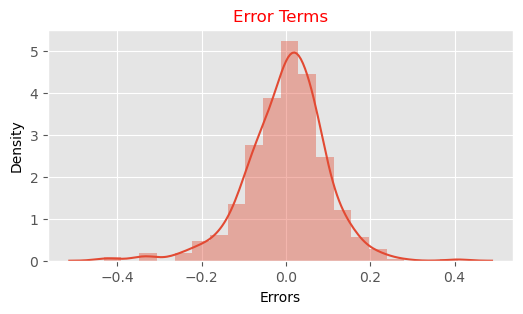

In [103]:
# Plot the histogram of the error terms to confirm linear regression rules
plt.figure(figsize=(6,3))
sns.distplot((y_train - y_train_count), bins = 20)
plt.title('Error Terms' , fontdict={'fontsize':12,'fontweight':10,'color':'Red'} )                
plt.xlabel('Errors')  
plt.show()

**Observation**<br>
1. Error terms are normally distributed.<br>
2. Mean of the error terms are hovering around 0.<br>
3. Requirements for linear regression for errors terms of the expected model are met.

**3.2 Patterns in the residuals wrt fitted feature count**

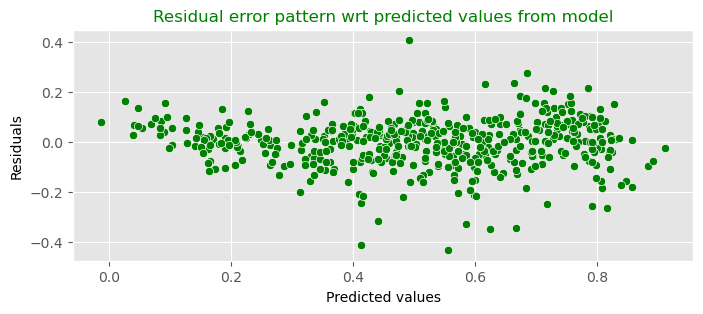

In [104]:
plt.figure(figsize=(8,3))
plt.title('Residual error pattern wrt predicted values from model',fontdict={'fontsize':12,'fontweight':5,'color':'Green'})
sns.scatterplot(x=y_train_count, y=(y_train-y_train_count), color='Green')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.show()

**Observation**<br>
There is no visible pattern when plotting the residuals(errors) against the predicted values(total predicted demand) from 
the train dataset.

**3.3 Error terms have constants variance (homoscedastiticy)**

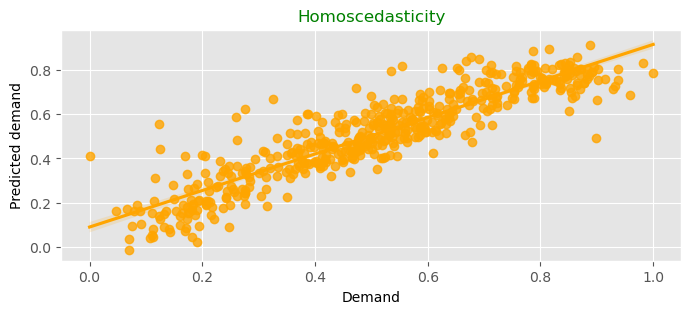

In [105]:
plt.figure(figsize=(8,3))
plt.title('Homoscedasticity',fontdict={'fontsize':12,'fontweight':5,'color':'Green'})
sns.regplot(x=y_train, y=y_train_count, color='Orange')
plt.xlabel('Demand')
plt.ylabel('Predicted demand')
plt.show()

**Observation**<br>
Residuals(errors) from the final model has homoscedasticity properties. Therefore all the rules regarding Linear regression for this model have been satisfied.

**4. Plot of actual and predicted values from the training dataset**

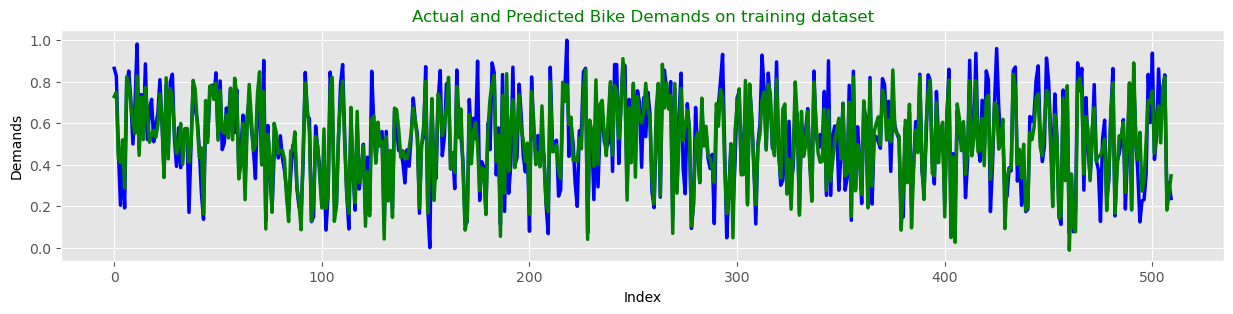

In [106]:
#Actual vs Predicted
c = [i for i in range(0,len(X_train),1)]
plt.figure(figsize=(15,3))
plt.plot(c,y_train, color="blue", linewidth=2.5, linestyle="-") #actual values
plt.plot(c,y_train_count, color="green",  linewidth=2.5, linestyle="-") #predicted values
plt.title('Actual and Predicted Bike Demands on training dataset' ,
            fontdict={'fontsize':12,'fontweight':5,'color':'Green'})      
plt.xlabel('Index')                               
plt.ylabel('Demands')    
plt.show()

**Observation**<br>
Actual & predicated values are almost similar.

**5. Predictions on the test dataset using final model**

**5.1 Preprocessing of test dataset**

In [107]:
print(list(num_vars))

['temp', 'atemp', 'hum', 'windspeed', 'count', 'days_old']


In [108]:
#scaling test dataset
inp2_test[num_vars] = scaler.fit_transform(inp2_test[num_vars])
inp2_test.head()

,year,holiday,workingday,temp,atemp,hum,windspeed,count,days_old,Spring,...,Oct,Sep,Mon,Sat,Sun,Thu,Tue,Wed,Light_snrn,Misty
184,0,1,0,0.837006,0.778725,0.534178,0.149434,0.704300,0.249311,0,...,0,0,1,0,0,0,0,0,0,1
535,1,0,1,0.911212,0.855140,0.470416,0.231321,0.725421,0.732782,0,...,0,0,0,0,0,0,0,1,0,0
299,0,0,1,0.496111,0.492303,0.777809,0.443396,0.278853,0.407713,0,...,1,0,0,0,0,1,0,0,0,1
221,0,0,1,0.890149,0.805662,0.236670,0.449811,0.545512,0.300275,0,...,0,0,0,0,0,0,0,1,0,0
152,0,0,1,0.821776,0.749313,0.070723,0.682264,0.569148,0.205234,0,...,0,0,0,0,0,1,0,0,0,0


In [109]:
#split into y and X
y_test = inp2_test.pop('count')
X_test = inp2_test

In [110]:
print(list(X_train_m8.columns))

['const', 'year', 'workingday', 'temp', 'Spring', 'Winter', 'Jul', 'Sep', 'Light_snrn', 'Misty', 'Summer']


In [111]:
#drop the contants from the final model into a new variable
X_train_final = X_train_m8.drop(['const'],axis=1)
print(list(X_train_final))

['year', 'workingday', 'temp', 'Spring', 'Winter', 'Jul', 'Sep', 'Light_snrn', 'Misty', 'Summer']


In [112]:
# Now let's use our model to make predictions.

# Creating X_test_new dataframe by dropping variables from X_test
X_test_new = X_test[X_train_final.columns]

In [113]:
#add constant to the test model
X_test_new = sm.add_constant(X_test_new)

# Making predictions
y_test_count = lm.predict(X_test_new)

**5.2 Model evaluation on the test dataset using the final model determined from train dataset**

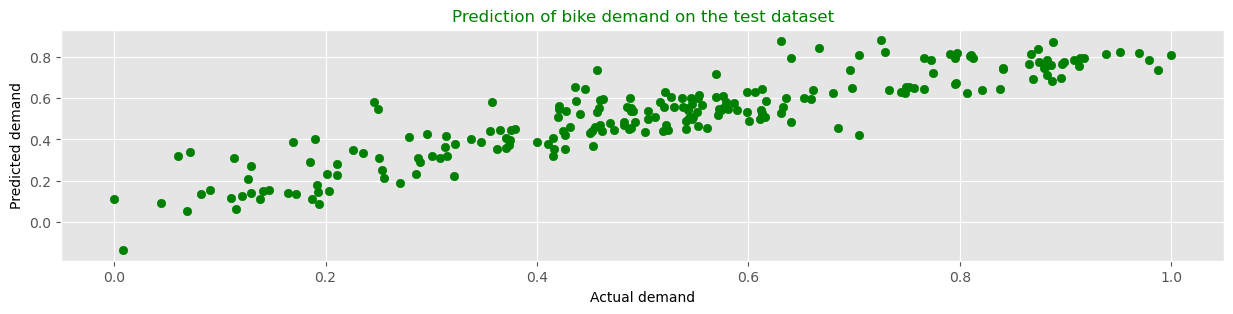

In [114]:
# Plotting y_test and y_pred to understand the spread
plt.figure(figsize=(15,3))
plt.scatter(y_test,y_test_count,color='Green')
plt.title('Prediction of bike demand on the test dataset', fontdict={'fontsize':12,'fontweight':5,'color':'Green'})   
plt.xlabel('Actual demand')                       
plt.ylabel('Predicted demand')         
plt.show()

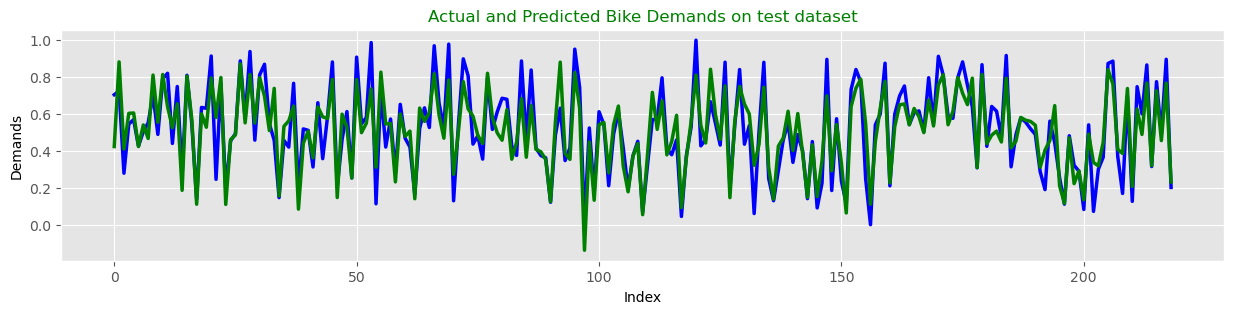

In [115]:
#Actual vs Predicted on test dataset
c = [i for i in range(0,len(X_test),1)]
plt.figure(figsize=(15,3))
plt.plot(c,y_test, color="blue", linewidth=2.5, linestyle="-") #actual values
plt.plot(c,y_test_count, color="green",  linewidth=2.5, linestyle="-") #predicted values
plt.title('Actual and Predicted Bike Demands on test dataset' ,
            fontdict={'fontsize':12,'fontweight':5,'color':'Green'})      
plt.xlabel('Index')                               
plt.ylabel('Demands')    
plt.show()

**Observation**<br>
Prediction on the test(unseen) dataset is also good using the final model.

**5.3 Calculate R2 score on the test dataset**

In [116]:
#test dataset
y_pred = y_test_count.copy()
r2_score(y_test, y_pred)

0.8051110371957242

In [117]:
#train dataset
r2_score(y_train, y_train_count)

0.8220039104200556

**5.4 Best fit line equation of the linear regression of the final model**

In [118]:
#coefficients
round(lm.params,4)

const         0.1318
year          0.2323
workingday    0.0248
temp          0.5023
Spring       -0.0777
Winter        0.0837
Jul          -0.0497
Sep           0.0778
Light_snrn   -0.2983
Misty        -0.0793
Summer        0.0361
dtype: float64

**Equation of the best fit line of the final model**
$count = (0.2323 * year) + (0.0248 * workingday) + (0.5023 * temp) - (0.0777 * Spring) + (0.0837 * Winter) - (0.0497 * Jul)
+ (0.0778 * Sep) - (0.2983 * Light_snrn) - (0.0793 * Misty) + (0.0361 * Summer) + 0.1318 $

## VI - Recommendations

1. Factors that affect the demand of the bike rentals are:<br>
1.1 Positive effect: year, workingday, temp, Winter, Sep & Summer.<br>
1.2. Negative effect : Spring, Jul, Light snow/rain & Misty.<br>
<br>
2. The model can predict upto 80.5% accuracy, therefore if BoomBikes takes no action on any of the identified features, 
they can still expect a demand of atleast a factor of 0.1318.<br>
<br>
3. Boombikes needs to be ready for demand with each passing year  & working days but especially when the temperatures are
high during Fall. <br>
<br>
4. Boombikes may need to pay special attention during Jul & Sep when the demand is expected to increase drastically in 
comparison to rest of the year.<br>
<br>
5. Demand may fall when there is light snow/rains or thunderstorms or scattered clouds irrespective of the day of week.<br>
<br>
6. Summer is another important factor that BoomBikes must pay attention to when finalizing on demand planning.<br>
<br>
7. Demands will also fall when it is misty or cloudy.<br>


        